In [ ]:
pip install torch torchvision torchaudio matplotlib seaborn scikit-learn Pillow numpy


In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
import os
data_dir = 'C:/Users/colloh/Desktop/Data/leaf_data'
print(os.listdir(data_dir))


['Train', 'Val']


In [46]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),       # Random horizontal flipping
        transforms.RandomRotation(20),           # Random rotation within 20 degrees
        transforms.RandomResizedCrop(224),       # Randomly resize and crop the image
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}


In [40]:
from torchvision import models

# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Freeze the layers to avoid updating them during training
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer to match the number of classes in your dataset
num_classes = 2  # Update based on your number of classes
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Now, only the final layer's parameters will be updated during training


In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [48]:
from torch.optim import lr_scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Reduce LR by 0.1 every 7 epochs


In [49]:
# Unfreeze the last few layers
for param in model.layer4.parameters():
    param.requires_grad = True


In [51]:
import torch.nn as nn

# Check if the last layer in model.fc is Linear and get its in_features
if isinstance(model.fc[-1], nn.Linear):
    in_features = model.fc[-1].in_features
else:
    in_features = model.fc[0].in_features  # Adjust depending on your model's structure

# Add dropout and a new fully connected layer
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, num_classes)
)


In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)


In [54]:
# Define transformations for the training and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Define dataset directories
data_dir = 'C:/Users/colloh/Desktop/Data/leaf_data'

# Load the dataset
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'Train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'Val'), data_transforms['val'])
}

# Create DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False)
}

# Get class names
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")


Classes: ['Bacterial leaf blight', 'Blight', 'Brown spot', 'Gray_Leaf_Spot', 'Healthy', 'Leaf smut', 'Miner', 'Phoma', 'Rust']


In [55]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model
model = CNNModel(num_classes=len(class_names))

# Check if GPU is available and move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [56]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [57]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if we get better accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)


Epoch 1/10
----------
train Loss: 1.2064 Acc: 0.6829
val Loss: 1.4601 Acc: 0.4361
Epoch 2/10
----------
train Loss: 0.5530 Acc: 0.7854
val Loss: 0.8308 Acc: 0.7256
Epoch 3/10
----------
train Loss: 0.4393 Acc: 0.8309
val Loss: 0.6857 Acc: 0.7782
Epoch 4/10
----------
train Loss: 0.3301 Acc: 0.8764
val Loss: 0.5348 Acc: 0.8008
Epoch 5/10
----------
train Loss: 0.2447 Acc: 0.9117
val Loss: 0.4544 Acc: 0.8609
Epoch 6/10
----------
train Loss: 0.1833 Acc: 0.9367
val Loss: 1.3621 Acc: 0.7895
Epoch 7/10
----------
train Loss: 0.1543 Acc: 0.9474
val Loss: 0.4936 Acc: 0.8496
Epoch 8/10
----------
train Loss: 0.1446 Acc: 0.9508
val Loss: 0.1786 Acc: 0.9361
Epoch 9/10
----------
train Loss: 0.1115 Acc: 0.9650
val Loss: 0.1791 Acc: 0.9474
Epoch 10/10
----------
train Loss: 0.0924 Acc: 0.9728
val Loss: 0.1125 Acc: 0.9662
Best val Acc: 0.9662


Validation Accuracy: 96.62%
Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.72      0.84        18
               Blight       0.98      0.97      0.97        60
           Brown spot       0.69      1.00      0.81        11
       Gray_Leaf_Spot       1.00      0.91      0.95        23
              Healthy       1.00      1.00      1.00        33
            Leaf smut       1.00      1.00      1.00        20
                Miner       1.00      1.00      1.00        30
                Phoma       1.00      1.00      1.00        25
                 Rust       0.94      1.00      0.97        46

             accuracy                           0.97       266
            macro avg       0.96      0.96      0.95       266
         weighted avg       0.97      0.97      0.97       266



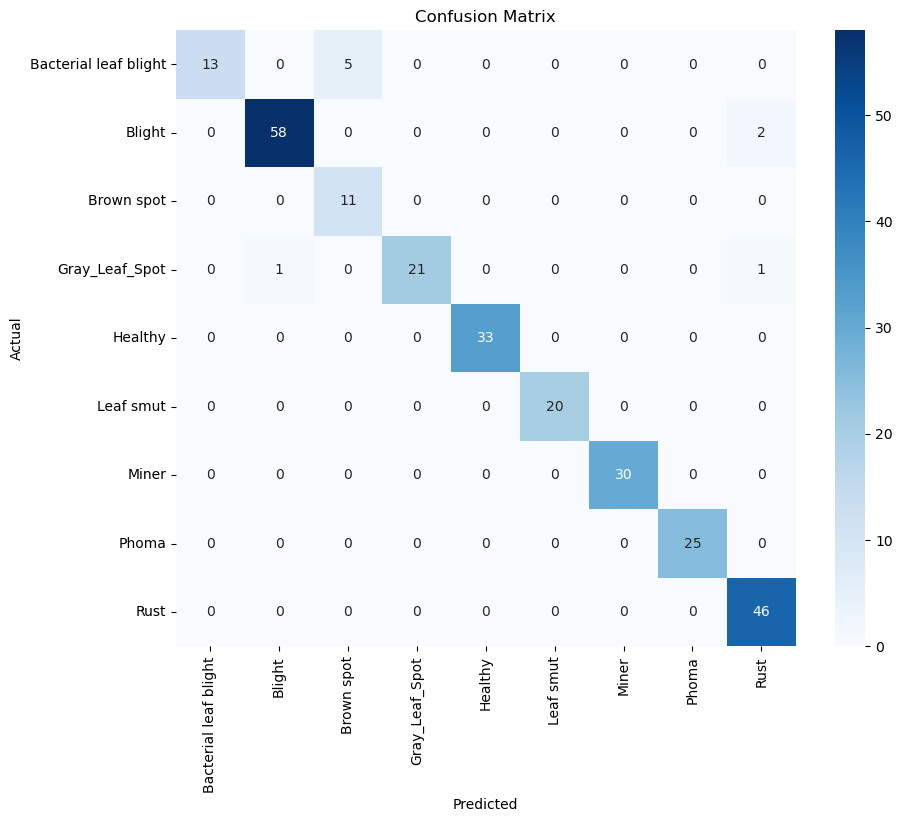

In [58]:
# Evaluation function to get accuracy and confusion matrix
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions on the validation set
y_pred, y_true = evaluate_model(model, dataloaders['val'])

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

# Function to predict the class of a given image
def predict_image(image_path, model, class_names, device):
    # Define the image transformation (similar to the validation transform)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the image to the same device as the model
    image = image.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(image)
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1)
        # Get the predicted class
        _, preds = torch.max(probs, 1)
    
    # Get the class name from the predicted class index
    predicted_class = class_names[preds.item()]
    
    return predicted_class, probs[0][preds.item()].item()

# Example usage:
image_path = 'C:/Users/colloh/Desktop/Data/coffee_leaf_diseases/Train/Phoma/338.jpg'
predicted_class, confidence = predict_image(image_path, model, class_names, device)
print(f'Predicted class: {predicted_class}, Confidence: {confidence:.4f}')


In [68]:
import joblib
import torch

# Path to save the model
model_path = 'C:/Users/colloh/Desktop/Data/leaf_data/Leaf_disease_predict_model.joblib'

# Save the model's state_dict
joblib.dump(model.state_dict(), model_path)
print(f"Model saved as {model_path}")


Model saved as C:/Users/colloh/Desktop/Data/leaf_data/Leaf_disease_predict_model.joblib
